In [1]:
%load_ext autoreload
%autoreload 2

#### Make sure you downloaded coco, flickr, glove. If not uncomment cell below.

In [ ]:
#!bash ../load_flickr8k.sh
#!bash ../load_glove.sh
#!bash ../load_coco.sh

In [2]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [ ]:
import nltk
nltk.download('punkt')

In [4]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
"""
If you want to construct vocab yourself just ignore this cell
"""
# download vocab_set.pkl
!gdown 1iOjqUxzwLGSQNYg28elCqM8EoJ6fkSna

In [18]:
train_from_scratch = False  # set `train_from_scratch = True` if you wish to train by yourself

In [32]:
import pickle

from datasets.flickr8k import Flickr8kDataset


DATASET_BASE_PATH = '../data/flickr8k/'
VOCAB = 'vocab_set.pkl'

vocab_set = None if train_from_scratch else tuple()

if not train_from_scratch:
    with open(VOCAB, 'rb') as f:
        vocab_set = pickle.load(f)

train_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set,
    device=device, return_type='tensor', load_img_to_memory=False)

if train_from_scratch:
    vocab_set = train_set.get_vocab()
    with open(VOCAB, 'wb') as f:
        pickle.dump(vocab_set, f)
    

vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)

val_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

test_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

train_eval_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)


print(
    f"The number of samples in:\ntrain: {len(train_set)};"
    + f" validation: {len(val_set)}; test: {len(test_set)}\n"
    + f"Vocabulary size: {vocab_size}; Max length of a sentence: {max_len};"
)

The number of samples in:
train: 30000; validation: 1000; test: 1000
Vocabulary size: 7707; Max length of a sentence: 40;


In [33]:
from torchvision import transforms
from torch.utils.data import DataLoader


BATCH_SIZE = 100


train_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.RandomCrop(224),  # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(224),  # get 224x224 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

train_set.transformations = train_transformations
val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations


eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, sampler=None, pin_memory=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn)

In [34]:
start_token = word2idx['<start>']
end_token = word2idx['<end>']
pad_token = word2idx['<pad>']
max_seq_len = max_len

In [22]:
import random
import torch
import numpy as np

from models.torch.densenet161_transformer import Captioner

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [35]:
from glove import embedding_matrix_creator
EMBEDDING_DIM = 300
EMBEDDING = f"GLV{EMBEDDING_DIM}"

embedding_matrix = embedding_matrix_creator(embedding_dim=EMBEDDING_DIM, word2idx=word2idx, GLOVE_DIR='../data/glove.6B/')
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7707/7707 [00:00<00:00, 597028.31it/s]

Embedding matrix shape: (7707, 300)


In [36]:
final_model = Captioner(10, 6, EMBEDDING_DIM, vocab_size, embedding_matrix, False).to(device)

In [25]:
from train_torch import evaluate_model
from train_transformer import train_model


In [26]:
from utils_torch import check_create_dir
from metrics import *
from utils_torch import *
import numpy as np

In [27]:
MODEL = final_model.name

if train_from_scratch:
    check_create_dir(f'saved_models/{MODEL}')
    MODEL_NAME = f'saved_models/{MODEL}/{MODEL}_b{BATCH_SIZE}_emd{EMBEDDING}'
    NUM_EPOCHS = 20
    print(MODEL_NAME)
    
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_set.pad_value)
    acc_fn = accuracy_fn(ignore_value=train_set.pad_value)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
    min_val_loss = float('Inf')

    sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
    corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
    tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)
    train_loss_min = float('Inf')
    val_bleu4_max = 0.0
        
    for epoch in range(NUM_EPOCHS):
        train_loss = train_model(
            desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}',
            model=final_model,                                                                      
            optimizer=optimizer,
            loss_fn=loss_fn,                                        
            train_loader=train_loader,
            acc_fn=acc_fn,
            pad_token=pad_token
        )

        with torch.no_grad():
            train_bleu = evaluate_model(
                desc=f'\tTrain Bleu Score: ',
                model=final_model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=train_eval_loader,
            )

            val_bleu = evaluate_model(
                desc=f'\tValidation Bleu Score: ',
                model=final_model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=val_loader,
            )

            print(f'Epoch {epoch + 1}/{NUM_EPOCHS}',
                ''.join([f'train_bleu{i}: {train_bleu[i]:.4f} ' for i in (1, 4)]),
                ''.join([f'val_bleu{i}: {val_bleu[i]:.4f} ' for i in (1, 4)]),
                )
            
            state = {
                'epoch': epoch + 1,
                'state_dict': final_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss_latest': train_loss,
                'val_bleu4_latest': val_bleu[4],
                'train_loss_min': min(train_loss, train_loss_min),
                'val_bleu4_max': max(val_bleu[4], val_bleu4_max),
                'train_bleus': train_bleu,
                'val_bleus': val_bleu,
            }

            torch.save(state, f'{MODEL_NAME}_latest.pt')

            if train_loss < train_loss_min:
                train_loss_min = train_loss
                torch.save(state, f'{MODEL_NAME}''_best_train_loss.pt')
                
            if val_bleu[4] > val_bleu4_max:
                val_bleu4_max = val_bleu[4]
                torch.save(state, f'{MODEL_NAME}''_best_val_bleu.pt')
        scheduler.step(train_loss)
        
    torch.save(state, f'{MODEL_NAME}_ep{NUM_EPOCHS:02d}_weights.pt')

Examples of evaluation

In [ ]:
"""
If you want to evaluate your trained model just ignore this cell
"""

!gdown 1to3u0KEOGZEhMxZmooscUepITgyEbvxH
!mkdir -p saved_models/densenet161_transformer
!mv densenet161_transformer_b100_emdGLV300_best_val_bleu.pt saved_models/densenet161_transformer/densenet161_transformer_b100_emdGLV300_best_val_bleu.pt

In [ ]:
PATH = f'saved_models/densenet161_transformer/densenet161_transformer_b100_emdGLV300_best_val_bleu.pt'
final_model.load_state_dict(torch.load(PATH, map_location=torch.device(device))['state_dict'])
final_model.eval()

In [38]:
torch.load(PATH, map_location=torch.device(device))['val_bleus'], torch.load(PATH, map_location=torch.device(device))['train_bleus']

([0.0,
  0.6563020474072612,
  0.4439026354172607,
  0.2986431441009807,
  0.20040442408046005],
 [0.0,
  0.6959171362081213,
  0.4996034593920619,
  0.3555811511011743,
  0.25028892209102066])

### Flickr

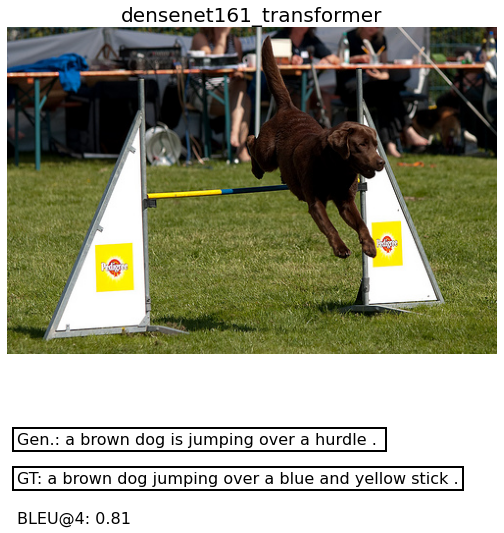

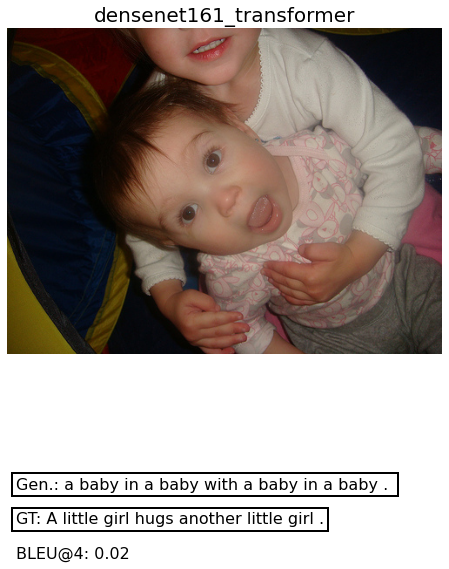

In [55]:
from utils_plot import *
dset = test_set
spatial = (
    ((10, 425), (10, 465), (10, 505)),
    ((10, 530), (10, 570), (10, 610))
)


idx_range = get_best_and_worst_quality_captions(dset, final_model, idx2word, bleu_score_fn(4, 'corpus'))

idx2spatial = {i:v for i, v in zip(idx_range, spatial)}
display_images_with_captions(idx2spatial, dset, final_model, idx2word, bleu_score_fn(4, 'corpus'))